##  <p style="text-align: center;"> NX-421: Neural signals and signal processing, Miniproject-3: Variant 3
## <p style="text-align: center;"> Blind Source Separation

In [22]:
from scipy import io
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
sns.set() #sets the matplotlib style to seaborn style
from scipy.signal import butter
from scipy.signal import sosfiltfilt
import time
from scipy.ndimage import convolve1d
from scipy.stats import pearsonr

#Load Data
subj1_mat = io.loadmat('data/subj1_relevant_vars')
print(f"What kind of data structure are we working with? {type(subj1_mat)}")
print(f"What are the keys of the data structure? \n {list(subj1_mat.keys())}")
N_CHANNELS = 64

What kind of data structure are we working with? <class 'dict'>
What are the keys of the data structure? 
 ['__header__', '__version__', '__globals__', 'Fs', 'adjusted_class_new', 'adjusted_repetition_new', 'emg_flexors_new']


In [3]:
subject_1_data = { 
      "name": "subject 1",
      "sampling_frequency": subj1_mat['Fs'][0][0],
      "emg_signal": subj1_mat['emg_flexors_new'].reshape(subj1_mat['emg_flexors_new'].shape[0], 64),
      "hand_mouvement_label": subj1_mat["adjusted_class_new"].flatten(),
      "repetition_number": subj1_mat['adjusted_repetition_new'].flatten()
              }
subject_1_data

{'name': 'subject 1',
 'sampling_frequency': 2048,
 'emg_signal': array([[-2.62174390e-03,  5.27681156e-03, -2.18451561e-03, ...,
         -5.76251744e-03,  9.00453354e-05,  1.99540053e-03],
        [ 7.67341356e-04,  4.82311690e-03,  1.77563149e-03, ...,
         -6.34514565e-04, -1.39659565e-03,  1.62779713e-03],
        [ 1.12907929e-03,  2.35519449e-03,  1.16431533e-03, ...,
          4.15876743e-04,  1.69310909e-03, -2.84820543e-03],
        ...,
        [-2.22037103e-02, -2.87452224e-02, -2.78726110e-02, ...,
          1.11979423e-02,  5.59196816e-03, -8.04352873e-02],
        [-3.05781494e-02, -3.21687935e-02, -2.30645220e-02, ...,
          1.15614242e-02,  8.61868146e-03, -9.26885810e-02],
        [-3.49523027e-02, -3.76635850e-02, -2.13010508e-02, ...,
          3.31225234e-03,  3.51837337e-03, -6.21802392e-02]]),
 'hand_mouvement_label': array([ 0,  0,  0, ..., 30, 30, 30], dtype=int8),
 'repetition_number': array([0, 0, 0, ..., 2, 2, 2], dtype=int8)}

### 1. Visualize and preprocess the data.

In [6]:
def preprocess_data(data, Wn = (5, 500), sub_sampling_rate=4):
    t = time.time()

    preprocessed = {}

    signal = data['emg_signal']
    fs = data['sampling_frequency']

    sos = butter(N=4, fs=fs, Wn=Wn, btype="bandpass", output="sos")
    emg_filtered = sosfiltfilt(sos, signal)

    emg_subsampled = emg_filtered[::sub_sampling_rate, :]
    emg_rectified =  np.abs(emg_subsampled)
    weights = np.ones(300)
    emg_envelopes = convolve1d(emg_rectified, weights=weights, axis=0)

    preprocessed['emg_signal'] = emg_envelopes
    preprocessed['sampling_frequency'] = fs/sub_sampling_rate
    preprocessed['hand_mouvement_label'] = data['hand_mouvement_label'][::sub_sampling_rate]
    preprocessed['repetition_number'] = data['repetition_number'][::sub_sampling_rate]
    preprocessed['name'] = data['name'] + 'preprocessed'

    print("Elapsed time: ", time.time() - t)
    return preprocessed

subject_1_preprocessed_data =preprocess_data(subject_1_data)

Elapsed time:  23.753801107406616


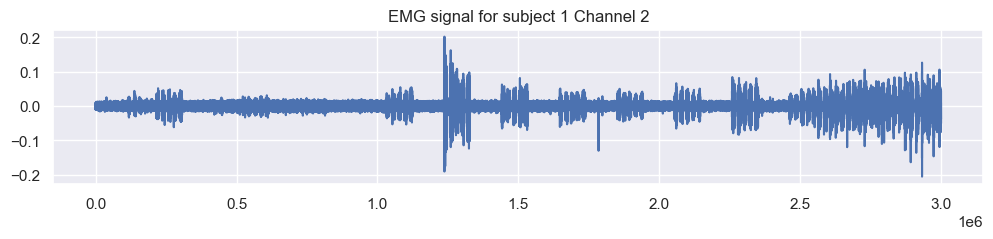

Sampling Frequency (Fs): 2048


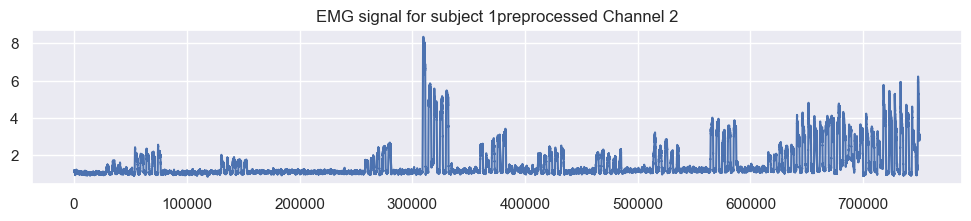

Sampling Frequency (Fs): 512.0


In [20]:
def visualize_data(data, all = False): 
    signal = data["emg_signal"]

    #hand_mouvements  = data['hand_mouvement_label']
    #unique_movements = len(np.unique(hand_mouvements))
    #palette = sns.color_palette("Spectral", n_colors = unique_movements)
    #color_coding = [palette[idx] for idx in hand_mouvements]
    
    channel_number =  2
    plt.figure(figsize=(12, 2))
    plt.plot(signal[:, channel_number-1])#, c = color_coding)
    if (all): 
        plt.plot(signal)
    plt.title(f"EMG signal for {data['name']} Channel {channel_number}")
    plt.show()
    print(f"Sampling Frequency (Fs): {data['sampling_frequency']}")

visualize_data(subject_1_data)
visualize_data(subject_1_preprocessed_data)

### 2. Compute the spatial synergies using different blind source separation algorithms (e.g. PCA, ICA, NMF). Are the synergies stable?

In [9]:
signal = subject_1_preprocessed_data['emg_signal']
from sklearn.decomposition import NMF
from sklearn.decomposition import FastICA
from sklearn.decomposition import PCA

n_components = 3
nmf = NMF(n_components=n_components, init="nndsvda", max_iter=500)
W_nmf = nmf.fit_transform(signal)
H_nmf = nmf.components_
print("W, H shape for nmf",W_nmf.shape, H_nmf.shape)

ica = FastICA(n_components=n_components, max_iter=500, random_state=0)
W_ica= ica.fit_transform(signal)
H_ica = ica.components_
print("W, H shape for ica", W_ica.shape, H_ica.shape)

pca = PCA(n_components=n_components)
W_pca = pca.fit_transform(signal)
H_pca = pca.components_
print("W, H shape for pca", W_pca.shape, H_pca.shape)

W, H shape for nmf (750000, 3) (3, 64)
W, H shape for ica (750000, 3) (3, 64)
W, H shape for pca (750000, 3) (3, 64)


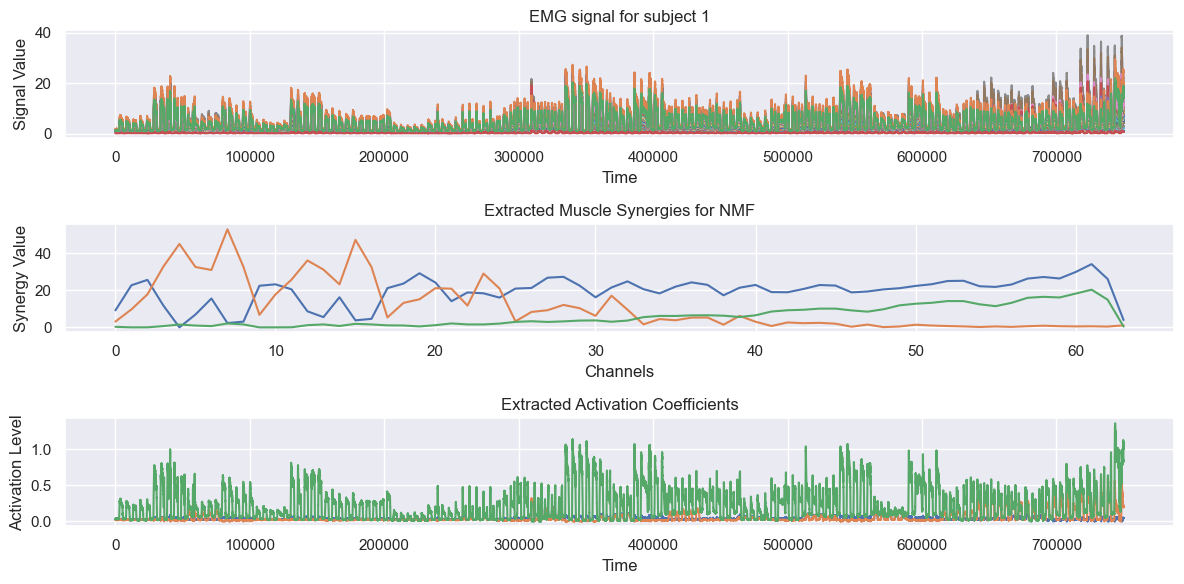

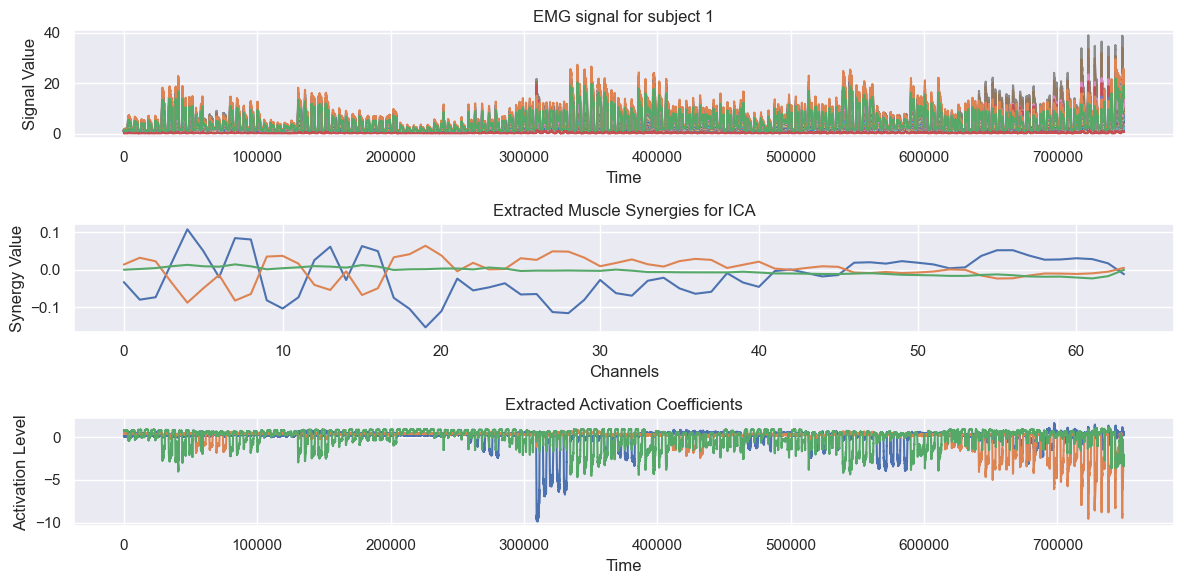

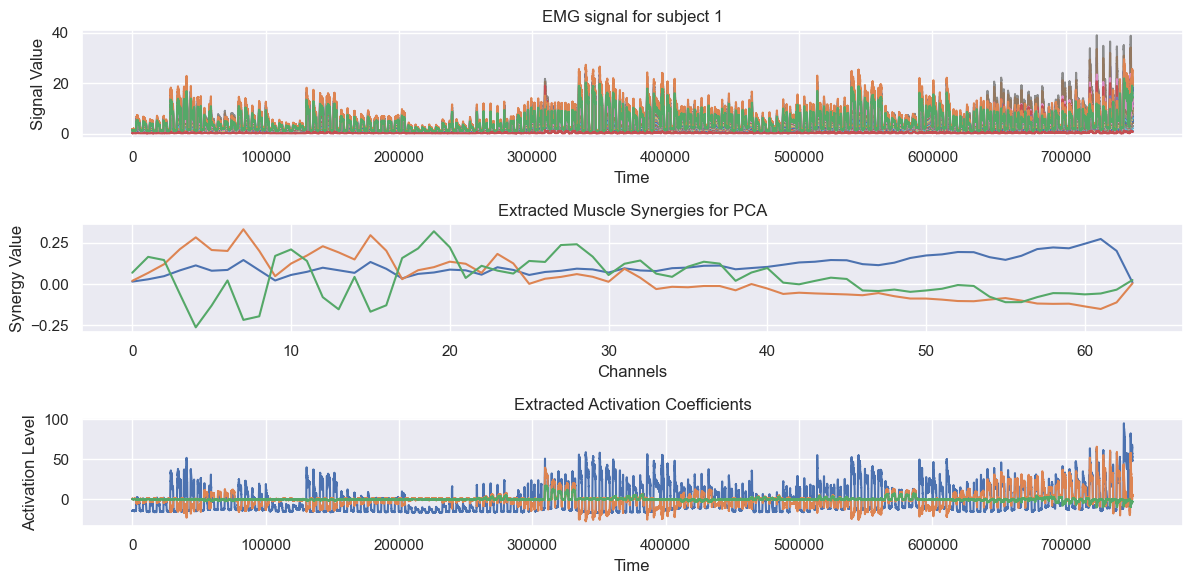

In [19]:
def visualize_synergies(W, H, signal, names = ["EMG signal", "W", "H"], all = True): 
    
    if (all):
        fig, ax = plt.subplots(3, 1, figsize = (12, 6))
        ax[0].plot(signal)
        ax[0].set_title("EMG signal" + names[0])
        ax[0].set_xlabel('Time')
        ax[0].set_ylabel('Signal Value')

        ax[1].plot(H.T)
        ax[1].set_title('Extracted Muscle Synergies' + names[1])
        ax[1].set_xlabel('Channels')
        ax[1].set_ylabel('Synergy Value')

        ax[2].plot(W)
        ax[2].set_title('Extracted Activation Coefficients' + names[2])
        ax[2].set_xlabel('Time')
        ax[2].set_ylabel('Activation Level')
        plt.tight_layout()
        plt.show()
    else: 
        plt.figure(figsize=(12, 2))
        plt.plot(H.T)
        plt.title('Extracted Muscle Synergies' + names[1])
        plt.xlabel('Channels')
        plt.ylabel('Synergy Value')
        plt.show()


visualize_synergies(W_nmf, H_nmf, signal=subject_1_preprocessed_data['emg_signal'], names = [" for subject 1", " for NMF", ""])
visualize_synergies(W_ica, H_ica, signal=subject_1_preprocessed_data['emg_signal'], names = [" for subject 1", " for ICA", ""])
visualize_synergies(W_pca, H_pca, signal=subject_1_preprocessed_data['emg_signal'], names = [" for subject 1", " for PCA", ""])

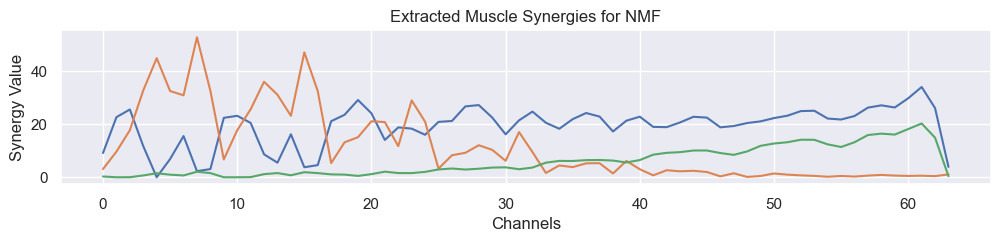

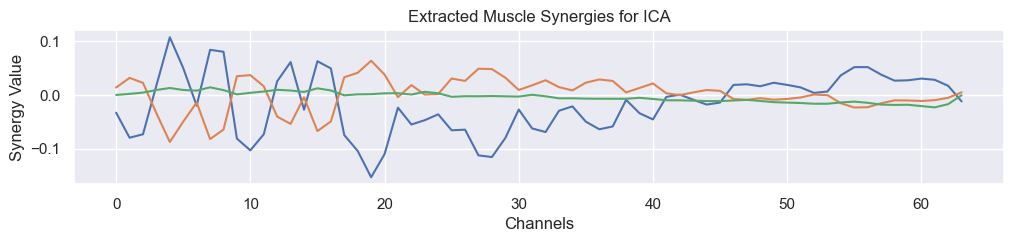

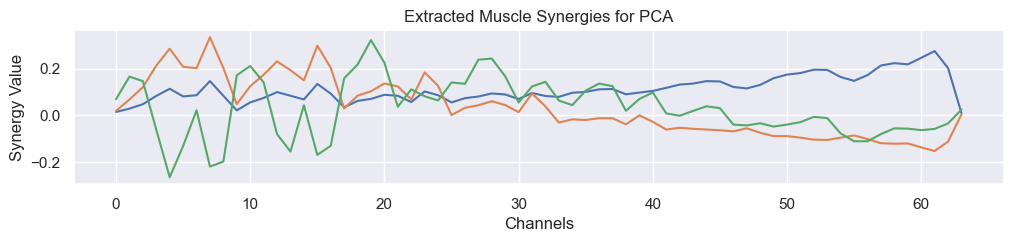

In [21]:
visualize_synergies(W_nmf, H_nmf, signal=subject_1_preprocessed_data['emg_signal'], names = [" for subject 1", " for NMF", ""], all = False)
visualize_synergies(W_ica, H_ica, signal=subject_1_preprocessed_data['emg_signal'], names = [" for subject 1", " for ICA", ""], all = False)
visualize_synergies(W_pca, H_pca, signal=subject_1_preprocessed_data['emg_signal'], names = [" for subject 1", " for PCA", ""], all = False)

To calculate the stability we can use the Synergy Stability Coefficient

In [24]:
#Synergy stability based off of Muscle synergy stability and human balance maintenance by Tytus Wojtara (2014)
def compute_ssi(synergies_list): #Synergies as a list of matrix synergies
    
    ssi_sum = 0

    number_of_trials = len(synergies_list)
    number_of_muscle_synergies = synergies_list[0].shape[0]

    p = number_of_trials
    k = number_of_muscle_synergies

    w = synergies_list
    for i in range(1, k + 1):
        inner_sum = 0
        
        for l in range(p):
            for q in range(p):
                if l != q:
                    correlation, pval = pearsonr(w[l][i], w[q][i])
                    inner_sum += correlation

        ssi_sum += (2 / (p * (p - 1))) * inner_sum
    ssi = 1 / k * ssi_sum

    return ssi

compute_ssi([W_nmf, W_ica, W_pca])